# Gaussian Clustering with Expectation Maximization

Let's generate three gaussian clusters of varying size/location and try seperating these into seperate clusters of data. These clusters can represent any datatype, however the key in this notebook is to introduce a Bayesian method of seperating them.

Here we will introduce the Expectation Maximization (EM) algorithm. First let's generate some artificial clusters to try and cluster.

In this example we will assume we know the number of overall clusters in our dataset to begin with. If we don't know the number of clusters we can use an additional parameter and maximise as we would usually. This will be covered in another notebook.

First let's generate our data: 

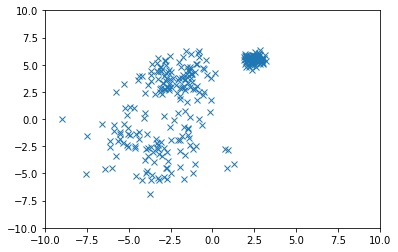

In [2]:
import numpy
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib

mean_1 = [-2.0,4.0]
mean_2 = [-3.5,-2.0]
mean_3 = [2.5,5.5]

cov_1 = [[1,0],
         [0,1]]
cov_2 = [[4,0],
         [0,4]]
cov_3 = [[0.1,0],
         [0,0.1]]
samples = 100

dataset_1 = [numpy.random.multivariate_normal(mean_1,cov_1) for i in range(samples)]
dataset_2 = [numpy.random.multivariate_normal(mean_2,cov_2) for i in range(samples)]
dataset_3 = [numpy.random.multivariate_normal(mean_3,cov_3) for i in range(samples)]
dataset_total = numpy.concatenate((dataset_1, dataset_2, dataset_3))

plt.plot(dataset_total[:,0],dataset_total[:,1],'x')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()

# EM Algorithm

Expectation maximization is a probabilistic method of modelling the data. Here we want to calculate the probability of some set of $k$ clusters means given a set of $n$ data, which are our points plotted above:

$$ P(x_1,\dots,x_n | \mu_1,\dots,\mu_k) = \prod^n_j P(x_j | \mu_1,\dots,\mu_k) $$

If let all our cluster be absorbed into a single piece of notation for simplicity:

$$ P(x_1,\dots,x_n | \theta)=  \prod^n_{j=1} P(x_j | \theta) $$

We now need to marginalise over the clusters, which is to say: We need to calculate the probability of each data point belonging to each clusters, so for our three cluster example, we calculate three probabilities:

$$  P(x_1,\dots,x_n | \theta) = \prod^n_{j=1} \sum^K_{i=0} P(x_j, y_i = j | \theta) $$

Which can be simplified to:

$$  P(x_1,\dots,x_n | \theta) = \prod^n_{j=1} \sum^K_{i=0} P(x_j | y_i = j \theta) $$

And as we are modelling our data as a mixture of gaussian mixtures:

$$  P(x_1,\dots,x_n | \theta) = \prod^n_{j=1} \sum^K_{i=0} \mathcal{N}(\mu_i, \Sigma) $$ 

The expectation maximization algorithm is split into two steps:

1) Expectation step: calculate the probability that a point belongs to each cluster. This is done for every data point and every proposed cluster. Here we calculate the marginal likelihood:

$$ P(y_j = i | x_j, \theta^{t-1} ) \propto P(x_j | y_j = i, \theta^{t-1}) $$

$$ P(y_j = i | x_j, \theta^{t-1} ) = \frac{P(x_j | y_j = i, \theta^{t-1})}{\sum^K_{i=1}P(x_j | y_j = i, \theta^{t-1})}$$ 

We denote this ratio as $r$:

$$ r = \frac{P(x_j | y_j = i, \theta^{t-1})}{\sum^K_{i=1}P(x_j | y_j = i, \theta^{t-1})} $$

2) Maximisation step: maximise the likelihood so that we converge on the correct means and variances for each cluster. We calculate the new mean and variance for our current iteration based on the values of the previous iteration.

$$ Q(\theta^t | \theta^{t-1} ) = \sum^N_{k=1} \sum^K_{i=1} P(y_j = i | x_j, \theta^{t-1})ln( P (x_j, y_j = i | \theta^t) $$

$$ u^t = \sum^N_{j=1} r_j x_j $$

$$ \Sigma^t = \sum^N_{j=1} r_j Cov(x_j,x_j) $$

We repeat this over a number of iterations and calculate the probability of each data point belonging to each cluster. It is not difficult to see that this can scale poorly for very large data sizes! However there are several areas where this code can be parallelised and will run relatively quickly if written in a compiled language such as C/C++.


In [3]:
from scipy.stats import multivariate_normal as mvn

def covariancef(X,Y,mean_x,mean_y,N):
    sum = 0.0
    j = 0
    for x,y in zip(X,Y):
        sum += ((x - mean_x)*(y - mean_y))
        j += 1
    return sum/N


## Index key:
# i - classes
# j - data

def expectation_step(data,means,sigmas,no_classes,no_data):
   
    r = numpy.zeros(shape=(no_classes,no_data))
    for i in range(no_classes):
        for j in range(no_data):
            denom = 0.0
            for ii in range(no_classes):
                denom += mvn.pdf(data[j],means[ii],numpy.diagflat(numpy.exp(sigmas[ii])))
            r[i,j] = mvn.pdf(data[j],means[i],numpy.diagflat(numpy.exp(sigmas[i])))/denom
    return r

def maximization_step(data,r,no_classes,no_data):
    
    # What we are looking to maximise the likelihood of
    means = numpy.zeros(shape=(no_classes,2)) # 2 = no. of dimensions in this particular example
    sigmas = numpy.zeros(shape=(no_classes,2)) # 2 = no. of dimensions in this particular example
    
    # Calculate Weights
    weights = numpy.zeros(shape=(no_classes,no_data))
    for i in range(no_classes):
        for j in range(no_data):
            weights[i,j] = r[i,j]/numpy.sum(r[i,:])
    # Calculate new cluster parameters.
    for i in range(no_classes):
        for j in range(no_data):
            means[i,:] += weights[i,j]*data[j,:]
        sigmas[i,:] = numpy.log(numpy.sum(weights[i,:]) * covariancef(data[i,:],data[i,:],means[i],means[i],no_data))
    return means,sigmas

# General Parameters
max_iters=200
no_cent = 5
max_no_centers = 30

# For the E-Step:
mean_expec = numpy.zeros(shape=(no_cent,dataset_total.shape[0],2))
var_expec = numpy.zeros(shape=(no_cent,dataset_total.shape[0],2))

# For the M-Step:
mu_chain = numpy.zeros(shape=(no_cent, max_iters,2))
var_chain = numpy.zeros(shape=(no_cent, max_iters,2))
mu_chain[0,:,:] = 1
mu_chain[1,:,:] = -1
mu_chain[2,:,0] = 5
mu_chain[2,:,1] = -2
var_chain[:,:,:] = 1


# Find Clusters over N iterations
for i in range(max_iters-1):
    r = expectation_step(dataset_total, mu_chain[:,i],var_chain[:,i],no_cent,dataset_total.shape[0])
    new_means,new_sigmas = maximization_step(dataset_total,r,no_cent,dataset_total.shape[0])
    mu_chain [:,i+1,:] = new_means
    var_chain [:,i+1,:] = new_sigmas                
                

Print our cluster means and covariances:

In [10]:
#Cluster Means
print("Means:")
print(mu_chain[:,-1,:])

#Cluster Variances (some numerical instability here?)
print("Clusters: ")
print(1/numpy.sqrt(numpy.exp(var_chain[:,-1,:])))

print("R: ")
print(numpy.sum(r, axis=1))



Means:
[[ 2.47605317  5.50272442]
 [-5.06026133 -0.905579  ]
 [-2.75787858 -3.4499629 ]
 [-3.18074567  3.58272825]
 [-1.37287892  3.71657007]]
Clusters: 
[[4.21023199 2.50392391]
 [2.08222815 3.44251914]
 [2.51789273 2.32923743]
 [2.26559518 4.68396883]
 [3.7887385  2.20885715]]
R: 
[100.          31.40202156  60.60209812  44.49713244  63.49874788]


## Split data into clusters / Plot

Next is to use our derived means and covariance matrices to split the data into our clusters and draw our clusters.

We'll run the expectation step one last time to get the probabilities of a point belonging to a cluster.

In [5]:
lastr = expectation_step(dataset_total, mu_chain[:,-1], var_chain[:,-1], no_cent,dataset_total.shape[0])
print(lastr.shape)
lastr[2,200:230]

cluster_locations = numpy.zeros(shape=dataset_total.shape[0])
cluster_locations = numpy.argmax(lastr,axis=0)

(5, 300)


## Plotting

We can plot the data seperately by just using the argmax of the data, as described in our mathematics above. 

Additionally it is also helpful to plot the ellipses which denote the covariances of our dataset. This can be done using the covariance matrix which mathematically describes a "quadric" or quadratic surface in matrix form. 

In the same way we can do principial component analysis by diagonalising the covariance matrix, we do the exact same here:

$$ \Sigma = VLV^T $$

After find the eigenvectors and eigenvalues, we can calculate the shape of the ellipse by modelling it as N orthogonal vectors scaled using the eigenvalues as:

$$ W = 2\sqrt{2W} $$ 

The eigenvalues give us our sense of scale or size of the ellipse, but the eigenvectors describe the overall orientation. Firstly it useful to divide by the norm of the vector to recover our eigenvectors in units of the basis vectors:

$$ V^\prime = \frac{V}{||V||} $$

We now have some vector, in this case of two dimensions, which we can do a simple arctan of to find the angle of the ellipse:

$$ \phi = tan^{-1}\Bigg[\frac{V^{\prime}_{0}}{V^{\prime}_{1}} \Bigg]$$

Matplotlib expects the angle in angles so we can convert from radians to degrees using the simple:

$$ 180 + \frac{\phi}{\pi} $$

We then add it to the plot along with our clusters and mean centres. Easy!

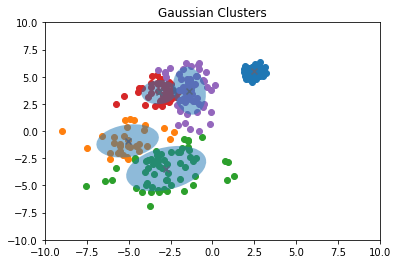

In [6]:
splot = plt.subplot(1,1,1)
# Seperate dataset into clusters, plot seperately.
for j in numpy.arange(no_cent):
    ind = numpy.where(cluster_locations==j)
    data = dataset_total[ind,:]
    data = data[0,:,:]
    ax = plt.scatter(data[:,0],data[:,1])
    cov = numpy.cov(data[:,0],data[:,1])
        
    # Plot ellipses denoting covariance.    
    w,v = linalg.eigh(cov)
    w = 2. * numpy.sqrt(2.) * numpy.sqrt(w)
    u = v[0] / linalg.norm(v[0])
    angle = numpy.arctan(v[0,1]/v[0,0])
    angle = 180. * angle/numpy.pi
    
    ell = matplotlib.patches.Ellipse(mu_chain[j,-1,:],w[0],w[1],180. + angle)
    ell.set_clip_box(splot)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

# Plot cluster centres as cross.
plt.scatter(mu_chain[:,-1,0],mu_chain[:,-1,1],marker='x')    
plt.title("Gaussian Clusters")
plt.xlim((-10,10))
plt.ylim((-10,10))
plt.show()